# Rate analysis

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

## Import data

In [70]:
biscuit_1 = pd.read_csv('data/tr-1.csv')
biscuit_2 = pd.read_csv('data/tr-2.csv')
biscuit_3 = pd.read_csv('data/tr-3.csv')

biscuits = [biscuit_1, biscuit_2, biscuit_3]

In [3]:
dunk_data = pd.read_csv('data/dunking-data.csv')
unidentified_pore_data = pd.read_csv('data/microscopy-data.csv')
pore_data = pd.merge(unidentified_pore_data, dunk_data, on = ['gamma', 'phi', 'eta', 'L', 't'], how = 'left')

In [78]:
digestive_dunk = dunk_data[dunk_data['biscuit'] == 'Digestive']
hobnob_dunk = dunk_data[dunk_data['biscuit'] == 'Hobnob']
rich_dunk = dunk_data[dunk_data['biscuit'] == 'Rich Tea']

named_biscuits = np.unique(pore_data['biscuit'])
named_biscuits

array(['Digestive', 'Hobnob', 'Rich Tea'], dtype=object)

## Plot data

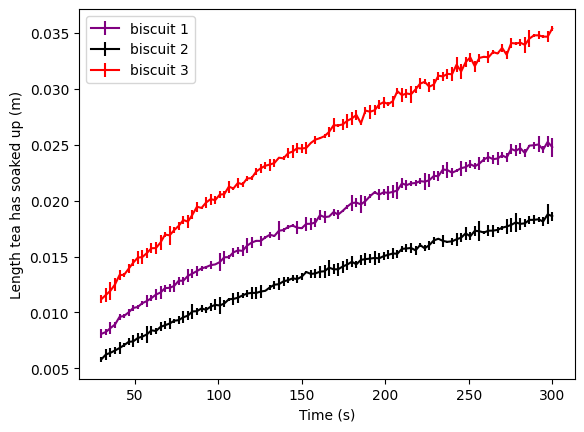

In [107]:
# Plot data on same graph

colours = ['purple', 'black', 'red']

fig, ax = plt.subplots()

for index, biscuit in enumerate(biscuits):
    plt.errorbar(biscuit['t'], biscuit['L'], yerr=biscuit['dL'], label=f'biscuit {index + 1}', c = colours[index])

ax.set_xlabel('Time (s)')
ax.set_ylabel('Length tea has soaked up (m)')
plt.legend()

plt.show()

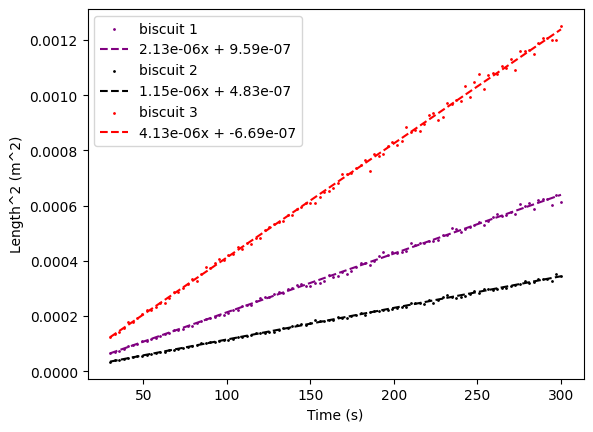

In [109]:
# Plot Length squared with lines of best fit

fig, ax = plt.subplots()

unknown_biscuit_ms = {}
for index, biscuit in enumerate(biscuits):

    biscuit['L^2'] = biscuit['L']**2
    x, y = biscuit['t'], biscuit['L^2']
    m, c = np.polyfit(x, y, 1)
    trend = [m * xi + c for xi in x]
    unknown_biscuit_ms[index+1] = m
    
    plt.scatter(x, y, label=f'biscuit {index + 1}', s =1, c = colours[index])
    plt.plot(x, trend, linestyle = '--', label = f'{"{:.2e}".format(m)}x + {"{:.2e}".format(c)}', c = colours[index])

ax.set_xlabel('Time (s)')
ax.set_ylabel('Length^2 (m^2)')
plt.legend()

plt.show()

## Identify which biscuit is which

Washburn equation can be manipulated to read:

$L^2 = \frac{\gamma r \cos{\phi}}{2 \eta}t $

and so therefore, since $L^2 \propto t$ the gradient of the graph above, is likely equal to $\frac{\gamma r \cos{\phi}}{2 \eta}$, should the equation hold true. We shall denote this gradient as m

In [110]:
# Find m for known biscuits and then compare to n for unkown biscuits

pore_data['L^2'] = pore_data['L']
pore_data['m'] = (pore_data['gamma'] * pore_data['r'] * np.cos(pore_data['phi']))/(2*pore_data['eta'])

named_biscuit_ms = {}

for biscuit in named_biscuits:
    named_biscuit_ms[biscuit] = np.mean(pore_data[pore_data['biscuit'] == biscuit]['m'])

print(named_biscuit_ms)
print(unknown_biscuit_ms)

{'Digestive': 3.693193578209031e-06, 'Hobnob': 2.2129051063722114e-06, 'Rich Tea': 1.252434469515079e-06}
{1: 2.1280689467026937e-06, 2: 1.1458709498695321e-06, 3: 4.13177462773337e-06}


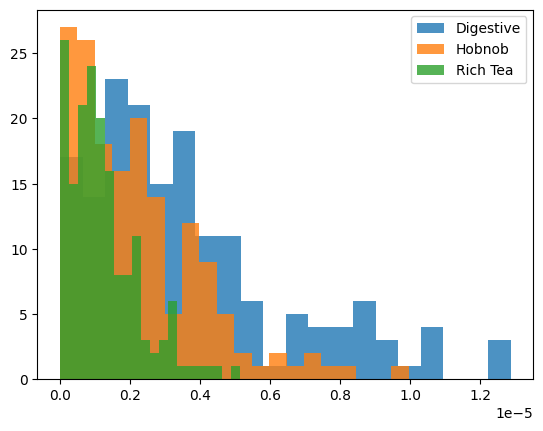

In [118]:
# Bin m for known biscuits

fig, ax = plt.subplots()

for index, biscuit in enumerate(named_biscuits):
    ax.hist(pore_data[pore_data['biscuit'] == biscuit]['m'], bins = 20, alpha = 0.8, label = biscuit)

ax.legend()
plt.show()

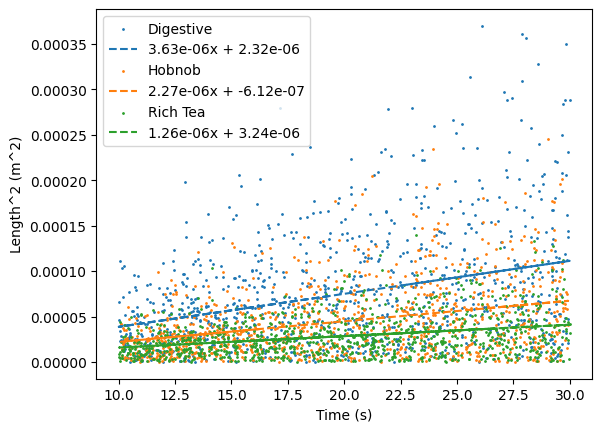

In [116]:
# Plots L^2 against t for dunk data

dunk_data['L^2'] = dunk_data['L']**2

fig,ax = plt.subplots()

for index, biscuit in enumerate(named_biscuits):
    x, y = dunk_data[dunk_data['biscuit'] == biscuit]['t'], dunk_data[dunk_data['biscuit'] == biscuit]['L^2']
    m, c = np.polyfit(x, y, 1)
    trend = [m * xi + c for xi in x]
    
    plt.scatter(x, y, label=biscuit, s =1)
    plt.plot(x, trend, linestyle = '--', label = f'{"{:.2e}".format(m)}x + {"{:.2e}".format(c)}')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Length^2 (m^2)')
ax.legend()

plt.show()

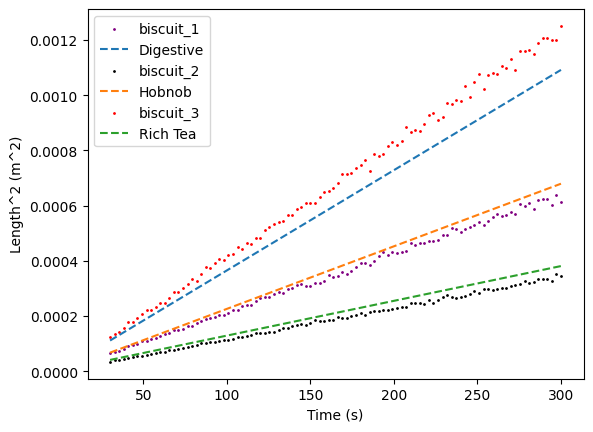

In [117]:
# Plot unknown biscuit data, against lines of best fit for known biscuits in dunk data

fig, ax = plt.subplots()

for index, biscuit in enumerate(named_biscuits):
    
    x, y = dunk_data[dunk_data['biscuit'] == biscuit]['t'], dunk_data[dunk_data['biscuit'] == biscuit]['L^2']
    xp, yp = biscuits[index]['t'], biscuits[index]['L^2']
    m, c = np.polyfit(x, y, 1)
    trend = [m * xi + c for xi in xp]
    
    plt.scatter(xp, yp, label = f'biscuit_{index+1}', s =1, c = colours[index])
    plt.plot(xp, trend, linestyle = '--', label = f'{biscuit}')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Length^2 (m^2)')

plt.legend()
plt.show()

## Testing how well Washburn predicts soak-rate

Based on above results it can be surmised that it is likely that:

biscuit 1 - Hobnob <br>
biscuit 2 - Rich Tea <br>
biscuit 3 - Digestive

In [130]:
biscuit_identifiers = {'biscuit_1': 'Hobnob', 'biscuit_2': 'Rich Tea', 'biscuit_3':'Digestive'}

In [131]:
# Get average biscuit pore radii

radii_named_biscuits = {}
for index, biscuit in enumerate(named_biscuits):
    radii_named_biscuits [biscuit] = np.mean(pore_data[pore_data['biscuit'] == biscuit]['r'])

radii_named_biscuits

{'Digestive': 8.034291866766941e-07,
 'Hobnob': 4.96368880029679e-07,
 'Rich Tea': 3.038970573515411e-07}

In [146]:
# Use to get pore radii for unkown biscuits

radii_biscuits = {}

for index, biscuit in enumerate(biscuits):
    radii_biscuits[f'biscuit_{index+1}'] = radii_named_biscuits[biscuit_identifiers[f'biscuit_{index+1}']]

In [147]:
# Define washburn function

gamma = 6.78e-2
phi = 1.45
eta = 9.93e-4

def washburn_length(df,r):

    return np.sqrt((gamma * r * df['t'] * np.cos(phi))/ ( 2 * eta))

In [148]:
# Predict L using washburn equation

for index, biscuit in enumerate(biscuits):
    biscuit['L_predicted'] = washburn_length(biscuit, radii_biscuits[f'biscuit_{index+1}'])

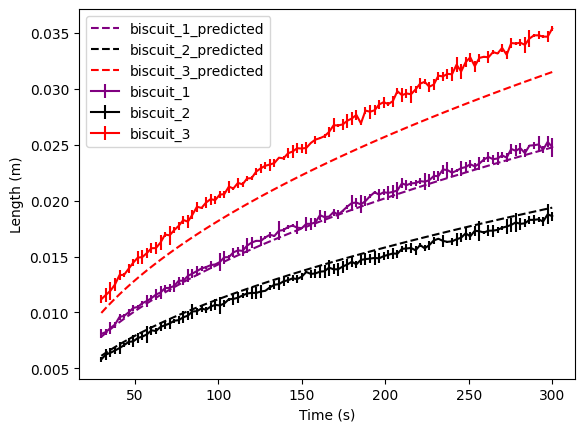

In [149]:
# Plot washburn predicted

fig, ax = plt.subplots()

for index, biscuit in enumerate(biscuits):

    ax.errorbar(biscuit['t'], biscuit['L'], yerr = biscuit['dL'], c = colours[index], label = f'biscuit_{index+1}')
    ax.plot(biscuit['t'], biscuit['L_predicted'], linestyle = '--', c = colours[index], label = f'biscuit_{index+1}_predicted')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Length (m)')
ax.legend()
plt.show()